# Dog Breed Identification 

The goal of this notebook is to create a classifier to estimate the breed of a dog from a picture. The data and idea comes from [this](https://www.kaggle.com/c/dog-breed-identification) Kaggle Competition. My approach to this problem is to use a pre-trained convolutional neural network for feature extraction, then replace the top of this network with a small neural network which will be trained to classify the images into one of 120 breeds in the training set. 

In [1]:
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000


/home/connor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [8]:
#keras specific imports 
from keras import Model, Input
from keras.layers import Dense, Flatten,GlobalMaxPool2D,Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from keras.applications import VGG16,vgg16
from keras.applications import VGG19,vgg19
from keras.applications import InceptionV3, inception_v3

In [10]:
NUMBER_CLASSES = 120

In [11]:
# This will create a generator that the keras model can train on from directories of images that I created earlier in 
# reorganize_images.py. It also will load and preprocess the validation set. 
def create_train_validation(processing_func,image_dim):
    data_gen = ImageDataGenerator(shear_range= 0.3,
                                      horizontal_flip= True,
                                      width_shift_range=0.3,
                                      height_shift_range = 0.3,
                                      preprocessing_function= (lambda x: processing_func(x)) )                                          

    train_generator = data_gen.flow_from_directory('train',
                                                       batch_size = 24,
                                                   target_size= (image_dim,image_dim),
                                                   class_mode= 'categorical')


#creates validation set
    X_val_path, y_val = [], []
    for folder in os.listdir('validation'):
        for path in os.listdir('validation/'+folder):
            y_val.append(folder)
            X_val_path.append('validation/'+folder+'/'+path)

    def prep_from_path(path):
        img = image.load_img(path, target_size = (image_dim,image_dim))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        x = processing_func(x)
        return x.reshape(image_dim,image_dim,3)


    X_val=[]
    for path in X_val_path:
        X_val.append(prep_from_path(path))

    X_val = np.array(X_val)

    class_map = train_generator.class_indices

    y_val = [class_map[y] for y in y_val]

    y_val = to_categorical(y_val)
    return train_generator, X_val, y_val

In [97]:
# creates a model with some number of units in the two hidden layers I am adding
def create_model(base_layers,layer1_units,layer2_units):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(layer1_units, activation = 'relu', name = '1')(X)
    X = Dense(layer2_units, activation = 'relu',name = '2')(X)
    predictions = Dense(NUMBER_CLASSES , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

# Creates a similar model but I've replaced the global max pooling with dropout
def create_model_no_pooling(base_layers,layer1_units,layer2_units):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = Flatten()(X)
    X = Dropout(.3)(X)
    X = Dense(layer1_units, activation = 'relu', name = '1')(X)
    X = Dense(layer2_units, activation = 'relu',name = '2')(X)
    predictions = Dense(NUMBER_CLASSES , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model


In [13]:
# A function to test top-X accuracy which is a common metric for classification problems with a large number of classes
def get_top_X_accuracy(actual,predictions,X= 5):
    actual = np.argmax(actual,axis = 1).reshape(-1,1)
    top_X = np.argsort(predictions, axis = 1)[:,-X:]
    acc = np.any( top_X == actual, axis  = 1)
    return np.mean(acc)

In [48]:
#functions for sanity checking
def show_and_predict_top_X(X,path,size,model,classdict):
    pylab.imshow(pylab.imread(path))
    prepped =prep_for_model(path,size)
    pred = model.predict(prepped).flatten()
    bestx = (np.argsort(pred)[::-1])[:X]
    output = []
    for p in bestx:
        prob = pred[p]
        class_ = classdict[p]
        output.append((class_,prob))
    print("Top {} breeds and probability:".format(X))
    for x in output:
        print("{} : {}".format(x[0], str(round(x[1],3))))
    
#preps an image for the model from a string file path        
def prep_for_model(path,size):
    img = image.load_img(path, target_size = (size,size) )
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = inception_v3.preprocess_input(x)
    return x
        


In [14]:
#to prevent overfitting, for the first model as it does not have dropout or regularization
#potentially these can be improvements on what I am currently doing
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = .01, 
                               patience = 5,
                               verbose = 1,
                               mode = 'min')


In [15]:
image_dim = 224
inception_v3_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape= (image_dim,image_dim,3))
model1 = create_model(inception_v3_base,500,200)

rmsprop = keras.optimizers.RMSprop(lr = .001, decay = .0001)
model1.compile(optimizer=rmsprop,loss = 'categorical_crossentropy',metrics = ['accuracy'])


train_generator, X_val, y_val = create_train_validation(inception_v3.preprocess_input,image_dim)
model1.fit_generator(generator = train_generator, 
                        epochs=40,
                            steps_per_epoch= 50, #there are 24 images per step so this is 1200 per epoch
                            callbacks = [early_stopping],
                            validation_data = (X_val,y_val),
                            workers=8,
                            use_multiprocessing=True,
                            verbose = 1) 


Found 9254 images belonging to 120 classes.
Epoch 1/40
50/50 [==============================] - 21s 429ms/step - loss: 6.3852 - acc: 0.0208 - val_loss: 4.6623 - val_acc: 0.0351
Epoch 2/40
50/50 [==============================] - 18s 368ms/step - loss: 4.7946 - acc: 0.0200 - val_loss: 5.0479 - val_acc: 0.0372
Epoch 3/40
50/50 [==============================] - 19s 372ms/step - loss: 4.5691 - acc: 0.0650 - val_loss: 3.8997 - val_acc: 0.1477
Epoch 4/40
50/50 [==============================] - 19s 378ms/step - loss: 4.1256 - acc: 0.1245 - val_loss: 3.0561 - val_acc: 0.2810
Epoch 5/40
50/50 [==============================] - 19s 377ms/step - loss: 3.7463 - acc: 0.1550 - val_loss: 2.2077 - val_acc: 0.4607
Epoch 6/40
50/50 [==============================] - 19s 378ms/step - loss: 3.3376 - acc: 0.2183 - val_loss: 1.8602 - val_acc: 0.5083
Epoch 7/40
50/50 [==============================] - 19s 377ms/step - loss: 3.1321 - acc: 0.2492 - val_loss: 1.8770 - val_acc: 0.5021
Epoch 8/40
50/50 [=======

In [16]:
preds1 = model1.predict(X_val)

In [17]:
get_top_X_accuracy(y_val,preds1,1)

0.6828512396694215

In [18]:
get_top_X_accuracy(y_val,preds1,5)

0.9349173553719008

In [19]:
get_top_X_accuracy(y_val,preds1,10)

0.9710743801652892

In [36]:
class_dict = {v:k for k,v in train_generator.class_indices.items()}

## Some sanity checks for fun with dogs that I like 

Top 5 breeds and probability:
labrador_retriever : 0.206
chesapeake_bay_retriever : 0.141
rottweiler : 0.135
schipperke : 0.098
giant_schnauzer : 0.091


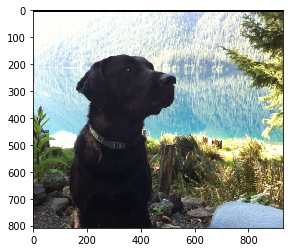

In [52]:
show_and_predict_top_X(5,'demo_dogs/jack.png',224,model1,class_dict)

Jack is a black lab but this picure is fairly dark and has poor contrase on his face. Still the model got it right, but with a lower probability than I'd like

Top 5 breeds and probability:
chihuahua : 0.152
ibizan_hound : 0.146
basenji : 0.134
old_english_sheepdog : 0.105
blenheim_spaniel : 0.071


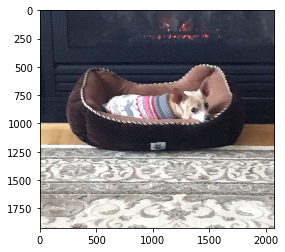

In [49]:
show_and_predict_top_X(5,'demo_dogs/izzy.jpg',224,model1,class_dict)

Izzy is mostly a chihuahua but also is mixed so this makes sense

Top 5 breeds and probability:
whippet : 0.916
italian_greyhound : 0.043
borzoi : 0.038
saluki : 0.003
irish_wolfhound : 0.0


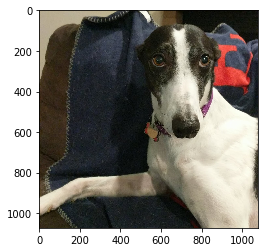

In [50]:
show_and_predict_top_X(5,'demo_dogs/athena.jpg',224,model1,class_dict)

Well athena is about 4 times the size of a whippet but that would be pretty hard to tell from this image, so I guess it is a reasonable mistake

Top 5 breeds and probability:
samoyed : 0.533
pomeranian : 0.206
keeshond : 0.178
groenendael : 0.042
west_highland_white_terrier : 0.009


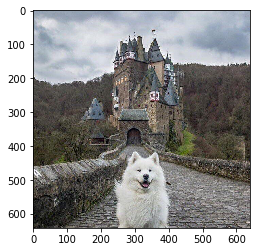

In [53]:
show_and_predict_top_X(5,'demo_dogs/castledog.jpg',224,model1,class_dict)

In [54]:
image_dim = 224
inception_v3_base2 = InceptionV3(weights = 'imagenet', include_top = False, input_shape= (image_dim,image_dim,3))
model2 = create_model_no_pooling(inception_v3_base2,500,200)

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-5)
model2.compile(optimizer=sgd,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [55]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = .01, 
                               patience = 2,
                               verbose = 1,
                               mode = 'min')

train_generator2, X_val2, y_val2 = create_train_validation(inception_v3.preprocess_input,image_dim)

Found 9254 images belonging to 120 classes.


In [56]:
model2.fit_generator(generator = train_generator2, 
                        epochs=50,
                            steps_per_epoch= 50, #there are 24 images per step so this is 1200 per epoch
                            #callbacks = [early_stopping],
                            validation_data = (X_val2,y_val2),
                            workers=8,
                            use_multiprocessing=True,
                            verbose = 1) 

Epoch 1/50
50/50 [==============================] - 23s 452ms/step - loss: 4.7931 - acc: 0.0258 - val_loss: 4.2273 - val_acc: 0.1157
Epoch 2/50
50/50 [==============================] - 19s 381ms/step - loss: 4.4594 - acc: 0.0858 - val_loss: 3.2921 - val_acc: 0.2665
Epoch 3/50
50/50 [==============================] - 19s 384ms/step - loss: 4.0897 - acc: 0.1350 - val_loss: 2.5924 - val_acc: 0.4256
Epoch 4/50
50/50 [==============================] - 19s 386ms/step - loss: 3.6552 - acc: 0.1908 - val_loss: 2.0351 - val_acc: 0.5217
Epoch 5/50
50/50 [==============================] - 19s 383ms/step - loss: 3.2781 - acc: 0.2651 - val_loss: 1.7272 - val_acc: 0.5754
Epoch 6/50
50/50 [==============================] - 19s 385ms/step - loss: 2.9726 - acc: 0.3092 - val_loss: 1.4983 - val_acc: 0.6136
Epoch 7/50
50/50 [==============================] - 19s 385ms/step - loss: 2.7433 - acc: 0.3633 - val_loss: 1.5386 - val_acc: 0.6302
Epoch 8/50
50/50 [==============================] - 20s 399ms/step - 

In [57]:
model2.optimizer.get_config()

{'decay': 9.999999747378752e-06,
 'lr': 0.009999999776482582,
 'momentum': 0.0,
 'nesterov': False}

In [58]:
preds2 = model2.predict(X_val2)

In [59]:
get_top_X_accuracy(y_val2,preds2,1)

0.7200413223140496

In [60]:
get_top_X_accuracy(y_val2,preds2,5)

0.9628099173553719

## Some more sanity checks for fun with dog picures I like

In [62]:
class_dict2 = {v:k for k,v in train_generator2.class_indices.items()}

Top 5 breeds and probability:
whippet : 0.992
saluki : 0.006
italian_greyhound : 0.002
borzoi : 0.001
ibizan_hound : 0.0


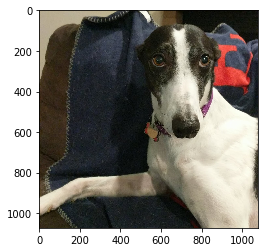

In [63]:
show_and_predict_top_X(5,'demo_dogs/athena.jpg',224,model2,class_dict2)

Top 5 breeds and probability:
labrador_retriever : 0.973
flat-coated_retriever : 0.009
american_staffordshire_terrier : 0.006
rhodesian_ridgeback : 0.003
greater_swiss_mountain_dog : 0.002


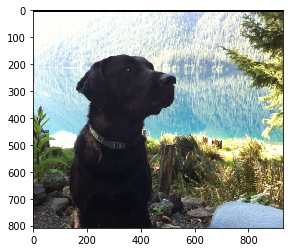

In [68]:
show_and_predict_top_X(5,'demo_dogs/jack.png',224,model2,class_dict)

Top 5 breeds and probability:
japanese_spaniel : 0.657
tibetan_terrier : 0.212
papillon : 0.095
shih-tzu : 0.035
lhasa : 0.0


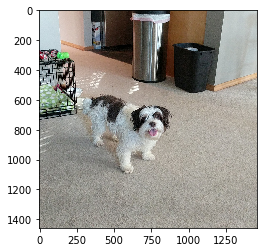

In [72]:
show_and_predict_top_X(5,'demo_dogs/wilson.jpg',224,model2,class_dict)

Wilson is a lhasa/shih-tzu mix I think, which are both in the top 5, and the breeds that were ranked higher are also very similar looking to him. In general its a fairly reasonable mistake.

In [79]:
#This function will make a dataframe of predictions for the test data to submit to Kaggle
def make_test_predictions(model,class_indicies,size = 224):
    images = os.listdir('dogs/test')
    results = {}
    for image in images:
        x = prep_for_model('dogs/test/'+image,size)
        yhat = model.predict(x).flatten()
        _id = image[:-4]
        results[_id] = {k:yhat[v] for k,v in class_indicies.items()}
    df = pd.DataFrame.from_dict(results, orient = 'index')
    return df
        
        

## Now to see how these models do on the test data

In [80]:
res = make_test_predictions(model1,train_generator.class_indices,224)

In [85]:
res.to_csv('model1results.csv',index_label='id')

This had an a score of 1.29 on the Kaggle test set when I submitted it

In [92]:
res2 = make_test_predictions(model2,train_generator2.class_indices,224)

In [93]:
res2.to_csv('model2results.csv',index_label='id')

This had a score of 1.22 on the Kaggle test set 

# Training a network on all the data to submit to Kaggle

In [94]:
image_dim = 224
data_gen = ImageDataGenerator(shear_range= 0.3,
                              horizontal_flip= True,
                              width_shift_range=0.3,
                              height_shift_range = 0.3,
                              preprocessing_function= (lambda x: inception_v3.preprocess_input(x)))                                         

submission_train_generator = data_gen.flow_from_directory('submission_train',
                                                          batch_size = 24,
                                                          target_size= (image_dim,image_dim),
                                                          class_mode= 'categorical')


Found 10222 images belonging to 120 classes.


In [95]:
inception_v3_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape= (image_dim,image_dim,3))
submission_model = create_model_no_pooling(inception_v3_base,500,200)

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-5)
submission_model.compile(optimizer=sgd,loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [96]:
submission_model.fit_generator(generator = submission_train_generator, 
                                epochs=50,
                                steps_per_epoch= 50, #there are 24 images per step so this is 1200 per epoch
                                workers=8,
                                use_multiprocessing=True,
                                verbose = 1) 

Epoch 1/50
50/50 [==============================] - 14s 288ms/step - loss: 4.7817 - acc: 0.0275
Epoch 2/50
50/50 [==============================] - 10s 206ms/step - loss: 4.4520 - acc: 0.0908
Epoch 3/50
50/50 [==============================] - 10s 207ms/step - loss: 4.0145 - acc: 0.1550
Epoch 4/50
50/50 [==============================] - 10s 207ms/step - loss: 3.6485 - acc: 0.2150
Epoch 5/50
50/50 [==============================] - 11s 217ms/step - loss: 3.2788 - acc: 0.2638
Epoch 6/50
50/50 [==============================] - 10s 208ms/step - loss: 3.1117 - acc: 0.2750
Epoch 7/50
50/50 [==============================] - 10s 209ms/step - loss: 2.9154 - acc: 0.3175
Epoch 8/50
50/50 [==============================] - 10s 209ms/step - loss: 2.7507 - acc: 0.3425
Epoch 9/50
50/50 [==============================] - 11s 221ms/step - loss: 2.5987 - acc: 0.3842
Epoch 10/50
50/50 [==============================] - 10s 208ms/step - loss: 2.4111 - acc: 0.4200
Epoch 11/50
50/50 [====================

In [98]:
results = make_test_predictions(submission_model,submission_train_generator.class_indices,224)

In [99]:
results.to_csv('modelresults.csv',index_label='id')

In [102]:
!kaggle competitions submit -c dog-breed-identification -f modelresults.csv -m "InceptionV3 base with dropout into two connected layers trained on full training data"

Successfully submitted to Dog Breed Identification

This model had a score of 1.18 on the test data, which is an expected slight improvement given that it had slightly more training data